# Performance comparison

In [52]:
import os
import random
import yaml
import re
import torch


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.colors import Normalize

from fault_management_uds.plots import visualize_metric_matrix


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import rain_gauge_color, condition_to_meta


# set random seed
seed = 42
np.random.seed(seed)
random.seed(seed)


## Load

In [53]:
#experiment_folder_name = 'benchmarking'

experiment_folder_name = 'benchmark'



experiment_folder = MODELS_DIR / experiment_folder_name

split = 0 # first split
relative_path = f'{split+1}_split/'


In [54]:

# Dictionary to store the results
runs = {}

experiment_names = [] # handle duplicates
lowest_steps_ahead = np.inf # ensure no index error
# iterate each run
for experiment_name in sorted(os.listdir(experiment_folder)):
    if experiment_name.startswith('.'):
        print(f'Skipping {experiment_name}')
        continue

    try:
        results = {}
        save_folder = MODELS_DIR / experiment_folder_name / experiment_name

        run_folder = save_folder / relative_path
        eval_folder = run_folder / 'evaluation'

        # Get relevant indo
        config = yaml.load(open(save_folder / 'config.yaml', 'r'), Loader=yaml.Loader)
        try:
            # load pkl _with cpu
            split_info = torch.load(save_folder / 'split_info.pkl', map_location='cpu')
            run_info = split_info[split]
            #  if the best_model_path, last_model_path, top_k_best_model_paths are not relative paths, then convert them to relative paths
            #if not os.path.isabs(run_info['best_model_path']):
            if '/' in run_info['best_model_path']:
                run_info['best_model_path'] = os.path.relpath(run_info['best_model_path'], run_folder)
                run_info['last_model_path'] = os.path.relpath(run_info['last_model_path'], run_folder)
                run_info['top_k_best_model_paths'] = {
                    k: os.path.relpath(str(v), run_folder) for k, v in run_info['top_k_best_model_paths'].items()
                }
            
            # Load the split info
            best_model_path = run_info['best_model_path'] if run_info['best_model_path'] else 'epoch=0'
            epoch = int(re.search(r'epoch=(\d+)', best_model_path).group(1))
            results['epoch'] = epoch
            results['training_time'] = run_info['training_time']
        except Exception as e:
            run_info = {
                'best_model_path': 'epoch=0',
                'training_time': 0
            }
            results['epoch'] = 0
            results['training_time'] = 0
        

        
        # Remove the date formatting of the experiment name
        pattern = r'\d{6}_\d{4}$'
        if re.search(pattern, experiment_name):
        #if '_' in experiment_name:
            experiment_name = '_'.join(experiment_name.split('_')[:-2])


        if experiment_name not in experiment_names:
            results['experiment_name'] = experiment_name
            experiment_names.append(experiment_name)
        else:
            print(f'Warning: {experiment_name} already exists')
            experiment_names.append(experiment_name)
            # count occurrences of name
            count = sum([1 for name in experiment_names if name == experiment_name])
            experiment_name = f'{experiment_name} ({count})'
            results['experiment_name'] = experiment_name


        data_types = ['val', 'test']
        for data_type in data_types:
            results[data_type] = {}
            step_MAEs = pd.read_csv(eval_folder / data_type / 'step_MAEs.csv', index_col=0)
            results[data_type]['step_MAEs'] = step_MAEs
            condition_MAEs = pd.read_csv(eval_folder / data_type / 'condition_MAEs.csv', index_col=[0, 1])
            results[data_type]['condition_MAEs'] = condition_MAEs
        
        # get the lowest steps ahead
        lowest_steps_ahead = min(lowest_steps_ahead, max(step_MAEs.index))
        runs[experiment_name] = results
        print(f'Loaded {experiment_name}')  

    except Exception as e:
        print(f'Error loading {experiment_name}: {e}')
        continue


print(f'Lowest steps ahead: {lowest_steps_ahead}')

Loaded use_embedding=False
Loaded use_embedding=True
Lowest steps ahead: 10


## 1 step ahead

In [55]:
data_type = 'test'

# folder to save the plots
plots_folder = FIGURES_DIR / 'experiments' / experiment_folder_name / data_type
plots_folder.mkdir(exist_ok=True, parents=True)


In [56]:
# create the dataframe
data = []

round_to = 5
for run in runs:
    experiment_name = runs[run]['experiment_name']
    step_MAEs = runs[run][data_type]['step_MAEs']
    data.append({
        #'run': run,
        'Experiment': f"{experiment_name}",
        '1-step MAE': step_MAEs.loc[1, 'Overall'],
        #'date': run,
    })

df = pd.DataFrame(data)
df = df.sort_values(by='1-step MAE', ascending=True)
# now round
df = df.round(round_to)
df

,Experiment,1-step MAE
0,use_embedding=False,0.00229
1,use_embedding=True,0.00230


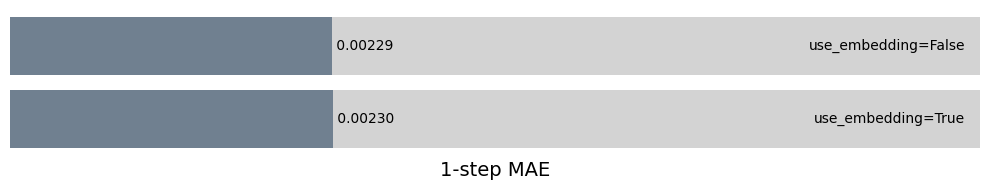

In [57]:
# plot the results
plt.figure(figsize=(10, 1+df.shape[0]//2))
# the highest value should be 1/3 of the bar width (to leave space for the text)
highest_value = df['1-step MAE'].max()
ax = sns.barplot(data=df, y='Experiment', x=[highest_value*3] * len(df), color='lightgrey', saturation=1) # create the background bars
sns.barplot(data=df, y='Experiment', x='1-step MAE', color='slategrey', saturation=1, ax=ax)

for lbl in ax.get_yticklabels():
     # add the y tick labels as right aligned text into the plot
     ax.text(0.985, lbl.get_position()[1], lbl.get_text(), transform=ax.get_yaxis_transform(), ha='right', va='center')
ax.bar_label(ax.containers[1], fmt=f' %.{round_to}f', label_type='edge') # add the values on the right side of the bars
ax.set_xticks([]) # remove the x ticks
ax.set_yticks([]) # remove the y ticks
ax.set_ylabel('') # remove the y label

#ax.xaxis.label.set_visible(False)
ax.xaxis.set_label('1-step MAE')
# adjust size of the x axis
ax.xaxis.label.set_size(14)
ax.margins(x=0) # remove the spacing at the right
sns.despine(left=True, bottom=True) # remove the spines
plt.tight_layout()
# save the plot
plt.savefig(plots_folder / 'overall_1_step_MAE.png', dpi=150)
plt.show()


## MAE as a function of steps ahead

In [58]:
# create the dataframe
data = np.zeros((lowest_steps_ahead, len(runs))) # (experiments, steps ahead) similar to (rows, columns)

round_to = 5
for i, run in enumerate(runs):
    experiment_name = runs[run]['experiment_name']
    step_MAEs = runs[run][data_type]['step_MAEs']
    data[:, i] = step_MAEs['Overall'].values

df = pd.DataFrame(data, columns=[f"{runs[run]['experiment_name']}" for run in runs], index=range(1, lowest_steps_ahead+1))
# sort columns by lowest 1-step MAE
df = df[df.loc[1].sort_values().index]
df

,use_embedding=False,use_embedding=True
1,0.002292,0.002297
2,0.002553,0.002601
3,0.002859,0.002929
4,0.003177,0.003245
5,0.003485,0.003541
6,0.003786,0.003828
7,0.004081,0.004109
8,0.004370,0.004384
9,0.004654,0.004656
10,0.004937,0.004928


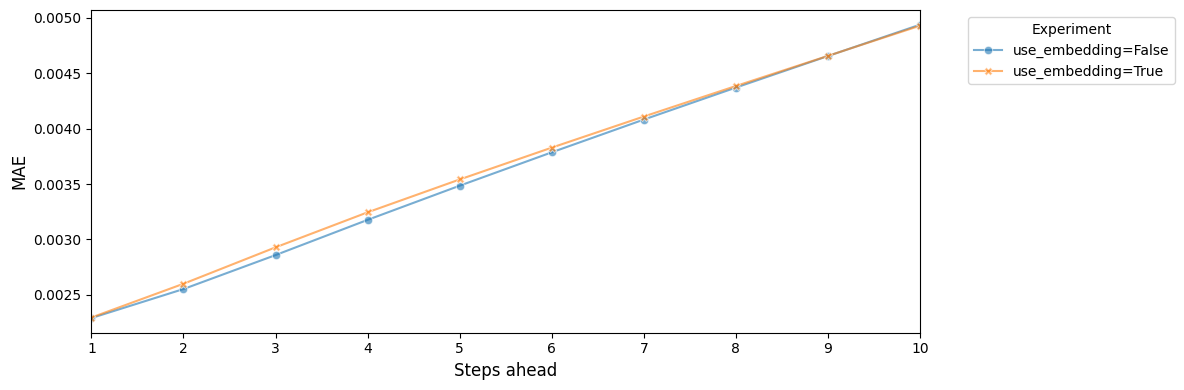

In [59]:
# Visualize the MAEs
plt.figure(figsize=(12, 4))
# plot the MAEs
sns.lineplot(data=df, alpha=0.6, dashes=False, markers=True)
plt.xticks(range(1, lowest_steps_ahead+1))
plt.xlim(1, lowest_steps_ahead)
# outside the plot
plt.legend(title='Experiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Steps ahead', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.tight_layout()
# save the plot
plt.savefig(plots_folder / 'overall_steps_ahead_MAE.png', dpi=150)
plt.show()


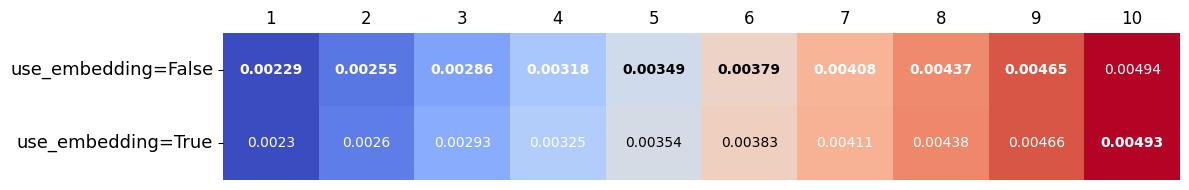

In [60]:
visualize_metric_matrix('MAE_steps_heatmap', df.T.iloc[::-1], 
                        'coolwarm', round_to, suffix=None, high_best=False, 
                        figsize=(12, 1+df.shape[1]//2), 
                        save_folder=plots_folder, 
                        top_n_bold=0, 
                        annotate_row_wise=False, ysize=13)

# saving
visualize_metric_matrix('MAE_steps_heatmap', df.T.iloc[::-1], 
                        'coolwarm', round_to, suffix=None, high_best=False, 
                        figsize=(12, 1+df.shape[1]//2), 
                        save_folder=None, 
                        top_n_bold=0,#df.shape[1], # TODO: work?
                        annotate_row_wise=False, ysize=13)


In [61]:
# # visualize like the confsion matrix
# plt.figure(figsize=(12, 4))
# sns.heatmap(df.T, annot=True, fmt=f'.{round_to}f', cbar=False, cmap='coolwarm')
# plt.xlabel('Steps ahead', fontsize=14)
# plt.tight_layout()
# # save
# plt.savefig(plots_folder / 'overall_steps_ahead_MAE_heatmap.png', dpi=150)
# plt.show()

In [62]:
df['Steps ahead'] = np.arange(1, lowest_steps_ahead+1)

In [63]:

# Reshape the data into long format
df_long = df.melt(
    id_vars=['Steps ahead'], 
    var_name='Experiment', 
    value_name='MAE'
)

# Plotly line plot
fig = px.line(
    df_long,
    x='Steps ahead',
    y='MAE',
    color='Experiment',
    markers=True,
    title="Overall Steps Ahead MAE"
)

# Customize layout
fig.update_layout(
    xaxis_title='Steps ahead',
    yaxis_title='MAE',
    legend_title='Experiment',
    legend=dict(x=1.05, y=1, xanchor='left', yanchor='top'),
    margin=dict(l=40, r=40, t=40, b=40), # Adjusts plot margins
    template='plotly_white'
)

# Show the plot
fig.show()


## Conditions and 1 step ahead

In [64]:
# create the dataframe
df = pd.DataFrame()

for i, run in enumerate(runs):
    experiment_name = runs[run]['experiment_name']
    condition_MAEs = runs[run][data_type]['condition_MAEs']
    condition_1_step_overall = condition_MAEs.loc[1, ['Overall']].rename(columns={'Overall': experiment_name}).T
    df = pd.concat([df, condition_1_step_overall])

n_conditions = df.shape[1]
# sort rows by overall 1-step MAE column
df = df.sort_values(by='Overall', axis=0)
df

Condition,Overall,Rain,Extreme,Dry
use_embedding=False,0.002292,0.003210,0.003727,0.002118
use_embedding=True,0.002297,0.003092,0.003444,0.002144


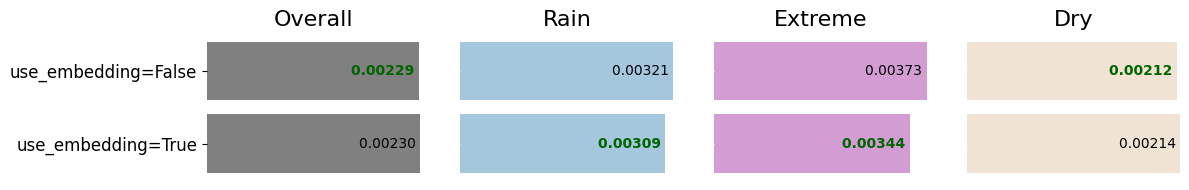

In [65]:
# Create a figure with an additional column for averages
fig, axs = plt.subplots(1, n_conditions, figsize=(12, 1+df.shape[0]//2))

for i, condition in enumerate(df.columns):
    axs[i] = sns.barplot(data=df, y=df.index, x=condition, ax=axs[i], saturation=0.5, color = condition_to_meta[condition]['color'])
    # add tooltips
    lowest_value = df[condition].min()
    for j, value in enumerate(df[condition]):
        color = 'black' if value != lowest_value else 'darkgreen'
        fontweight = 'normal' if value != lowest_value else 'bold'
        axs[i].text(value, j, f'{value:.{round_to}f} ', ha='right', va='center', fontsize=10, color=color, fontweight=fontweight)

    axs[i].set_title(condition, fontsize=16)
    axs[i].tick_params(axis='y', labelsize=12) if i == 0 else axs[i].tick_params(axis='y', labelsize=1, colors='white')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_xticks([])
    axs[i].margins(x=0)
    sns.despine(ax=axs[i], left=True, bottom=True)

plt.tight_layout()
plt.savefig(plots_folder / 'condition_1_step_MAE.png', dpi=150)
plt.show()


## Training time and epochs

In [66]:
runs[run][data_type]['step_MAEs'].loc[1, 'Overall']

0.0022965466234109

In [67]:
# create the dataframe
df = pd.DataFrame()

for i, run in enumerate(runs):
    experiment_name = runs[run]['experiment_name']
    epochs = runs[run]['epoch']
    training_time = runs[run]['training_time']
    _df = pd.DataFrame({
        'Experiment': experiment_name,
        'Epochs': epochs,
        'Training duration (min.)': training_time,
        '1-step MAE': runs[run][data_type]['step_MAEs'].loc[1, 'Overall']
    }, index=[experiment_name])

    df = pd.concat([df, _df])

# sort rows by overall 1-step MAE column
df = df.sort_values(by='1-step MAE')
# set experiment as index
df = df.set_index('Experiment')
n_conditions = df.shape[1]
df

,Epochs,Training duration (min.),1-step MAE
Experiment,,,
use_embedding=False,7,297.911951,0.002292
use_embedding=True,10,349.729599,0.002297


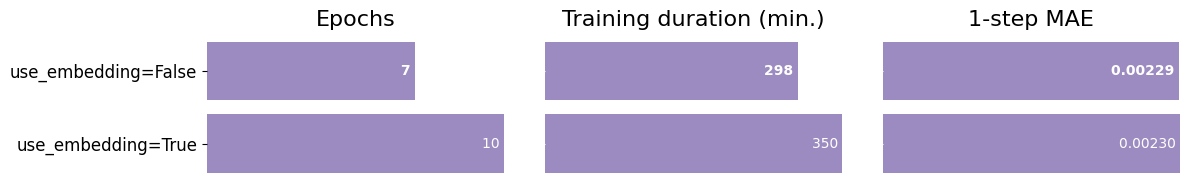

In [68]:
# Create a figure with an additional column for averages
fig, axs = plt.subplots(1, n_conditions, figsize=(12, 1+df.shape[0]//2))

for i, condition in enumerate(df.columns):
    sns.barplot(data=df, y=df.index, x=condition, ax=axs[i], saturation=0.5, color = 'mediumpurple')
    # add tooltips
    # Add tooltips on the opposite side of the bars
    lowest_value = df[condition].min()
    lowest_value = lowest_value if lowest_value != 0 else df[condition].sort_values().iloc[1]
    for j, value in enumerate(df[condition]):
        color = 'white' #if value != lowest_value else '#8cc4a0'
        fontweight = 'normal' if value != lowest_value else 'bold'
        round_to = 5 if condition == "1-step MAE" else 0
        axs[i].text(value, j, f'{value:.{round_to}f} ', ha='right', va='center', fontsize=10, color=color, fontweight=fontweight)
    axs[i].set_title(condition, fontsize=16)
    axs[i].tick_params(axis='y', labelsize=12) if i == 0 else axs[i].tick_params(axis='y', labelsize=1, colors='white')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_xticks([])
    axs[i].margins(x=0)
    sns.despine(ax=axs[i], left=True, bottom=True)

plt.tight_layout()
plt.savefig(plots_folder / 'parameters_1_step_MAE.png', dpi=150)
plt.show()


TODO: and n parameters??
